In [34]:
# --- 1. 라이브러리 및 모듈 임포트 ---

# 데이터 처리 라이브러리
import pandas as pd
import numpy as np

# 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 모델 및 평가 도구
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# 변수 중요도 확인 및 모델 해석
import eli5
from eli5.sklearn import PermutationImportance

# 시스템 및 경로 관련 라이브러리
import sys
import os
from datetime import datetime
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (baseline_code.ipynb 참고)
# Colab 또는 로컬 환경에 맞게 경로를 설정해야 할 수 있습니다.
import matplotlib.font_manager as fm
try:
    fe = fm.FontEntry(
        fname=r'../../font/NanumFont/NanumGothic.ttf',
        name='NanumGothic')
    fm.fontManager.ttflist.insert(0, fe)
    plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})
    plt.rc('font', family='NanumGothic')
except FileNotFoundError:
    print("나눔고딕 폰트를 찾을 수 없어 기본 폰트로 설정됩니다.")
    pass

In [35]:
# --- 2. 경로 설정 및 커스텀 로거 임포트 ---

# 현재 노트북 파일의 위치를 기준으로 프로젝트 루트 경로를 설정합니다.
# (예: notebooks 폴더에 있다면 ../../src 가 맞습니다)
try:
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../../src/log"))
    sys.path.insert(0, src_path)
    from logger import Logger
    print("Logger 모듈 로드 성공.")
    
except ImportError:
    print("[오류] Logger 모듈을 찾을 수 없습니다. src/log/logger.py 경로를 확인해주세요.")
    # Logger가 없어도 코드가 중단되지 않도록 임시 클래스 정의
    class Logger:
        def __init__(self, *args, **kwargs): pass
        def write(self, message, **kwargs): print(message)

Logger 모듈 로드 성공.


In [36]:
# --- 3. 로거 및 경로 초기화 ---

# 로그 파일이 저장될 경로 설정
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
LOG_DIR         = '../../data/logs/price_prediction_logs'
LOG_FILENAME    = f"price_prediction_{timestamp}.log"
LOG_PATH        = os.path.join(LOG_DIR, LOG_FILENAME)

# Directory 생성
os.makedirs(LOG_DIR, exist_ok=True)

# Logger 인스턴스 생성
logger = Logger(log_path=LOG_PATH)

# 데이터 및 제출 파일 경로 설정
SUBMISSION_DIR = '../../data/processed/submissions'
SUBMISSION_FILENAME = 'sample_submission.csv'
SUBMISSION_PATH = os.path.join(SUBMISSION_DIR, SUBMISSION_FILENAME)

logger.write("="*50)
logger.write(">> 아파트 가격 예측 모델링 시작")

2025-07-14 23:53:06 | ==================================================
2025-07-14 23:53:06 | >> 아파트 가격 예측 모델링 시작


In [37]:
# --- 4. 데이터 로드 ---

logger.write(">> 정제된 Train/Test 데이터를 로드합니다...")
try:
    # 학습 데이터와 테스트 데이터를 각각 로드
    train_df_clean = pd.read_csv('../../data/processed/cleaned_data/train_clean.csv')
    test_df_clean = pd.read_csv('../../data/processed/cleaned_data/test_clean.csv')
    
    # 두 데이터를 합치기 전에 isTest 컬럼으로 구분
    train_df_clean['isTest'] = 0
    test_df_clean['isTest'] = 1
    
    # 하나의 데이터프레임으로 합침
    df = pd.concat([train_df_clean, test_df_clean])
    
    logger.write(">> 데이터 로드 및 병합 완료.")
    
except FileNotFoundError:
    logger.write(f">> [오류] train_clean.csv 또는 test_clean.csv 파일을 찾을 수 없습니다.", print_error=True)
    df = None

2025-07-14 23:53:06 | >> 정제된 Train/Test 데이터를 로드합니다...
2025-07-14 23:53:07 | >> 데이터 로드 및 병합 완료.


2025-07-14 23:53:07 | >> 주요 변수 데이터 분포 시각화를 시작합니다...


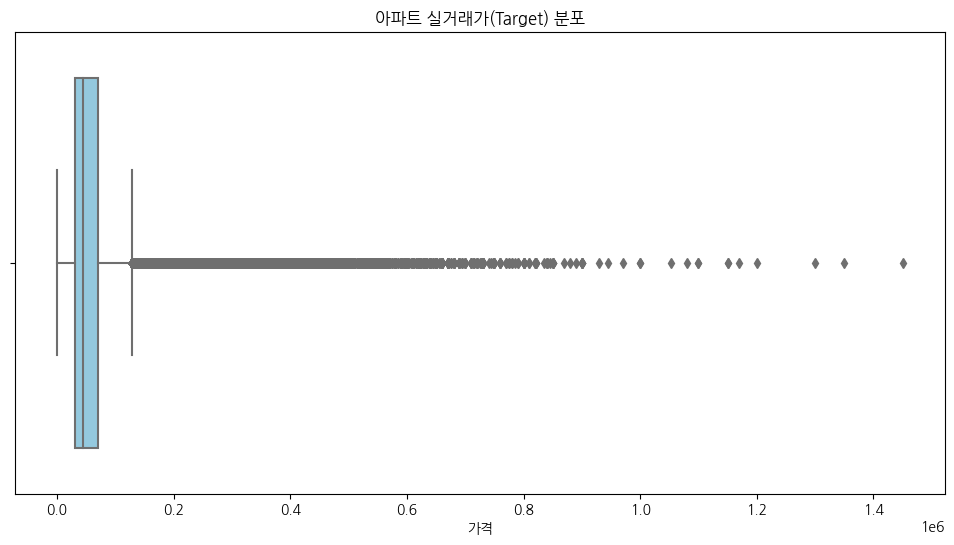

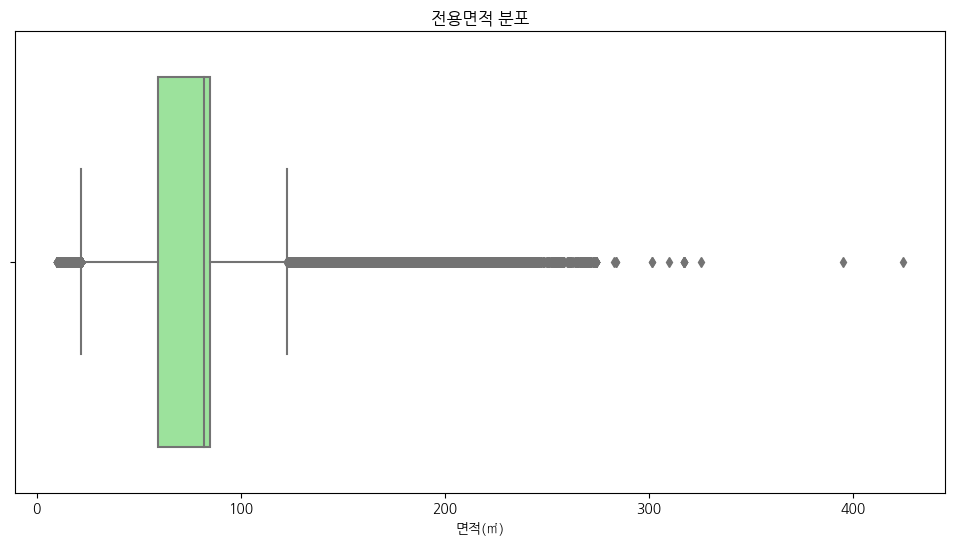

In [38]:
# --- 5. 데이터 시각화 ---
if df is not None:
    try:
        logger.write(">> 주요 변수 데이터 분포 시각화를 시작합니다...")
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=train_df_clean, x='target', color='skyblue')
        plt.title('아파트 실거래가(Target) 분포')
        plt.xlabel('가격')
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='전용면적', color='lightgreen') # 컬럼명 수정
        plt.title('전용면적 분포')
        plt.xlabel('면적(㎡)')
        plt.show()
    except Exception as e:
        logger.write(f">> [오류] 데이터 시각화 중 문제 발생: {e}", print_error=True)

In [39]:
# --- 6. 특성 공학 (Feature Engineering) (수정된 부분) ---

if df is not None:
    try:
        logger.write(">> 특성 공학을 통해 파생 변수를 생성합니다...")
        
        # 1. '신축여부' 파생변수 생성 (연식 컬럼 활용)
        # 연식 10년 이하를 신축으로 판단 (기준은 조절 가능)
        df['신축여부'] = df['연식'].apply(lambda x: 1 if x <= 10 else 0)

        # 2. 교통 관련 변수들을 올바른 숫자형으로 변환
        traffic_cols = [
            '지하철최단거리', '반경_1km_지하철역_수', '반경_500m_지하철역_수', 
            '반경_300m_지하철역_수', '버스최단거리', '반경_1km_버스정류장_수',
            '반경_500m_버스정류장_수', '반경_300m_버스정류장_수'
        ]
        for col in traffic_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            
            if '_수' in col:
                df[col] = df[col].astype(int)

        logger.write(">> 파생 변수 생성 및 데이터 타입 변환 완료.")
        
    except Exception as e:
        logger.write(f">> [오류] 특성 공학 중 문제 발생: {e}", print_error=True)

2025-07-14 23:53:07 | >> 특성 공학을 통해 파생 변수를 생성합니다...
2025-07-14 23:53:07 | >> 파생 변수 생성 및 데이터 타입 변환 완료.


In [40]:
# --- 7. 피처 선택 및 데이터 분리 ---

if df is not None:
    try:
        # isTest 컬럼을 사용해 train/test 데이터 분리
        train_df = df[df['isTest'] == 0].copy()
        test_df = df[df['isTest'] == 1].copy()
        
        # isTest 컬럼은 더 이상 필요 없으므로 제거
        train_df = train_df.drop('isTest', axis=1)
        test_df = test_df.drop('isTest', axis=1)
        
        logger.write(">> Train/Test 데이터 분리 완료.")

        # 예측에 사용할 피처(X)와 타겟(y) 정의
        features = [col for col in train_df.columns if col != 'target']
        
        X_train_raw = train_df[features]
        y_train = train_df['target']
        X_test_raw = test_df[features]

        # 범주형(object) 피처 자동 탐지
        categorical_features = X_train_raw.select_dtypes(include=['object']).columns.tolist()
        
        logger.write(f">> 예측에 사용할 피처 개수: {len(features)}개")
        logger.write(f">> 범주형 피처: {categorical_features}")
        
    except Exception as e:
        logger.write(f">> [오류] 피처 선택 및 데이터 분리 중 문제 발생: {e}", print_error=True)

2025-07-14 23:53:08 | >> Train/Test 데이터 분리 완료.
2025-07-14 23:53:08 | >> 예측에 사용할 피처 개수: 29개
2025-07-14 23:53:08 | >> 범주형 피처: ['계약일자', '자치구', '법정동', '브랜드등급']


In [41]:
# --- 8. 범주형 피처 인코딩 ---

if 'X_train_raw' in locals():
    try:
        # LabelEncoder를 사용하여 각 범주형 피처를 수치로 변환
        label_encoders = {}
        for col in categorical_features:
            le = LabelEncoder()
            all_categories = pd.concat([X_train_raw[col], X_test_raw[col]]).astype(str).unique()
            le.fit(all_categories)
            
            X_train_raw[col] = le.transform(X_train_raw[col].astype(str))
            X_test_raw[col] = le.transform(X_test_raw[col].astype(str))
            label_encoders[col] = le
            
        logger.write(">> 범주형 피처 Label Encoding 완료.")
        
    except Exception as e:
        logger.write(f">> [오류] 범주형 피처 인코딩 중 문제 발생: {e}", print_error=True)

2025-07-14 23:53:08 | >> 범주형 피처 Label Encoding 완료.


2025-07-14 23:53:09 | >> LightGBM 모델 학습을 시작합니다...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3050
[LightGBM] [Info] Number of data points in the train set: 888080, number of used features: 29
[LightGBM] [Info] Start training from score 57976.164328
2025-07-14 23:53:10 | >> 모델 학습 완료. Validation RMSE: 12579.1269
2025-07-14 23:53:10 | >> Permutation Importance를 계산합니다...
2025-07-14 23:53:20 | >> Permutation Importance 계산 완료.


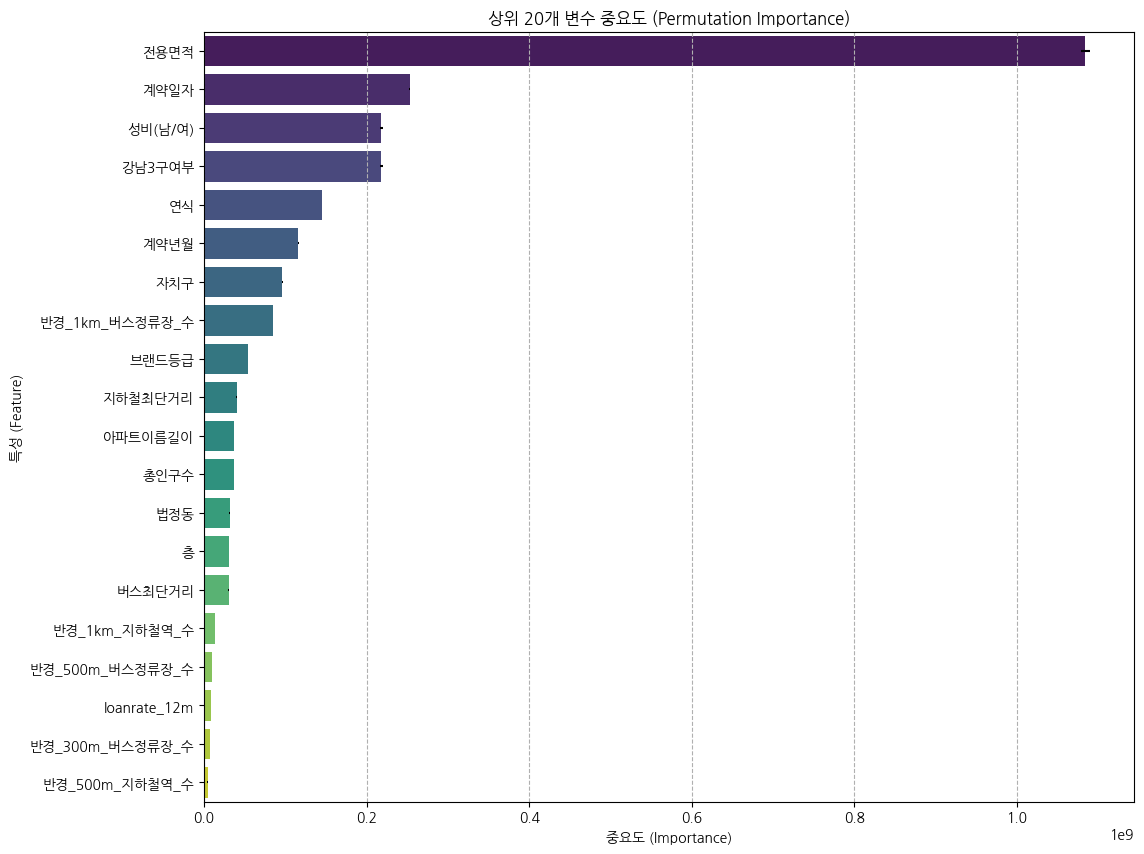

In [42]:
# --- 9. 모델 학습 및 평가 (개선된 부분) ---

if 'X_train_raw' in locals():
    try:
        X_train, X_val, y_train_split, y_val_split = train_test_split(
            X_train_raw, y_train, test_size=0.2, random_state=42
        )

        logger.write(">> LightGBM 모델 학습을 시작합니다...")
        lgbm = lgb.LGBMRegressor(random_state=42)
        lgbm.fit(X_train, y_train_split)
        y_pred = lgbm.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        logger.write(f">> 모델 학습 완료. Validation RMSE: {rmse:.4f}")

        logger.write(">> Permutation Importance를 계산합니다...")
        perm = PermutationImportance(lgbm, scoring='neg_mean_squared_error', random_state=42, n_iter=3).fit(X_val, y_val_split)
        logger.write(">> Permutation Importance 계산 완료.")
        
        # 결과를 DataFrame으로 변환
        importance_df = pd.DataFrame({
            'feature': X_val.columns,
            'importance': perm.feature_importances_,
            'std': perm.feature_importances_std_
        }).sort_values(by='importance', ascending=False)
        
        # 상위 20개 변수만 시각화 (너무 많으면 보기 어려우므로)
        top_n = 20
        plt.figure(figsize=(12, 10))
        sns.barplot(
            x='importance', 
            y='feature', 
            data=importance_df.head(top_n), 
            xerr=importance_df.head(top_n)['std'],
            palette='viridis'
        )
        plt.title(f'상위 {top_n}개 변수 중요도 (Permutation Importance)')
        plt.xlabel('중요도 (Importance)')
        plt.ylabel('특성 (Feature)')
        plt.grid(True, axis='x', linestyle='--')
        plt.show()
        
    except Exception as e:
        logger.write(f">> [오류] 모델 학습 및 평가 중 문제 발생: {e}", print_error=True)

2025-07-14 23:53:20 | >> 예측 오차 분석을 시작합니다...


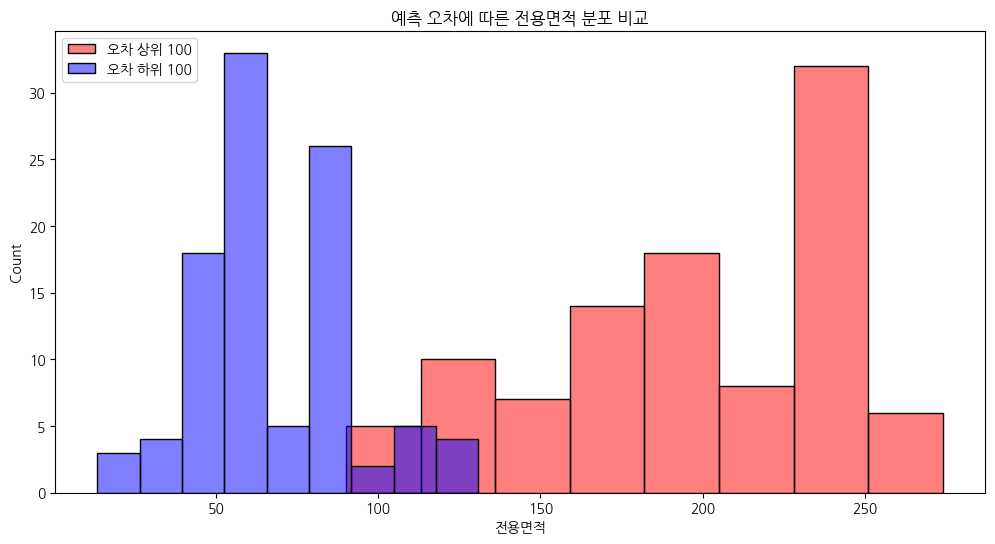

In [43]:
# --- 10. 예측 오차 분석 (Error Analysis) (추가된 부분) ---

if 'X_val' in locals():
    logger.write(">> 예측 오차 분석을 시작합니다...")
    X_val_analysis = X_val.copy()
    X_val_analysis['target'] = y_val_split
    X_val_analysis['pred'] = y_pred
    X_val_analysis['error'] = (X_val_analysis['target'] - X_val_analysis['pred']) ** 2

    # 오차가 큰 상위 100개와 작은 상위 100개 데이터 분리
    error_top100 = X_val_analysis.sort_values(by='error', ascending=False).head(100)
    best_top100 = X_val_analysis.sort_values(by='error', ascending=True).head(100)
    
    # '전용면적' 분포 비교 시각화
    plt.figure(figsize=(12, 6))
    # 수정: 컬럼명을 '전용면적(㎡)'에서 실제 데이터의 컬럼명인 '전용면적'으로 변경
    sns.histplot(data=error_top100, x='전용면적', color='red', alpha=0.5, label='오차 상위 100')
    sns.histplot(data=best_top100, x='전용면적', color='blue', alpha=0.5, label='오차 하위 100')
    plt.title('예측 오차에 따른 전용면적 분포 비교')
    plt.legend()
    plt.show()

In [44]:
# --- 11. 최종 예측 및 제출 파일 생성 ---
if 'X_train_raw' in locals():
    logger.write("\n>> 최종 모델 학습 및 제출 파일 생성을 시작합니다...")
    try:
        # 전체 학습 데이터로 최종 모델 재학습
        final_model = lgb.LGBMRegressor(random_state=42)
        final_model.fit(X_train_raw, y_train)
        
        # 테스트 데이터에 대한 예측 수행
        final_predictions = final_model.predict(X_test_raw)
        
        # 제출 파일 생성
        try:
            sample_submission_df = pd.read_csv(SUBMISSION_PATH)
            sample_submission_df['target'] = final_predictions
            sample_submission_df.to_csv(SUBMISSION_PATH, index=False)
        except FileNotFoundError:
            logger.write(">> sample_submission.csv 파일을 찾을 수 없어 새로 생성합니다.", print_error=True)
            submission_df = pd.DataFrame({'target': final_predictions})
            submission_df.to_csv(SUBMISSION_PATH, index=False)
            
        logger.write(f">> 제출 파일 '{SUBMISSION_PATH}' 생성 완료.")
    except Exception as e:
        logger.write(f">> [오류] 최종 예측 및 제출 파일 생성 중 문제 발생: {e}", print_error=True)
    
    logger.write(">> 모델링 종료")
    logger.write("="*50 + "\n")

2025-07-14 23:53:20 | 
>> 최종 모델 학습 및 제출 파일 생성을 시작합니다...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 1110101, number of used features: 29
[LightGBM] [Info] Start training from score 57968.361302
2025-07-14 23:53:22 | >> 제출 파일 '../../data/processed/submissions/sample_submission.csv' 생성 완료.
2025-07-14 23:53:22 | >> 모델링 종료
2025-07-14 23:53:22 | ==================================================

